# Quantum Approximate Optimization Algorithm 

Qiskit has an implementation of the Quantum Approximate Optimization Algorithm [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html) and this notebook demonstrates using it for a graph partition problem.

While QAOA can be directly used it often more convenient to use it in conjunction with the Optimization library. See the Optimization tutorials for more information.

In [1]:
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.applications import GraphPartition, OptimizationApplication, GraphOptimizationApplication

First we create a random graph and draw it so it can be seen.

In [2]:
num_nodes = 4
G = GraphOptimizationApplication.random_graph(num_nodes, num_edges=7, seed=48)

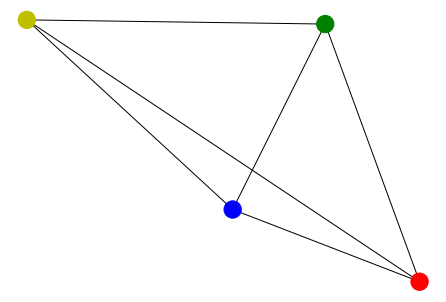

In [3]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

The brute-force method is as follows. Basically, we exhaustively try all the binary assignments. In each binary assignment, the entry of a vertex is either 0 (meaning the vertex is in the first partition) or 1 (meaning the vertex is in the second partition). We print the binary assignment that satisfies the definition of the graph partition and corresponds to the minimal number of crossing edges.

In [4]:
def brute_force():
    # use the brute-force way to generate the oracle
    def bitfield(n, L):
        result = np.binary_repr(n, L)
        return [int(digit) for digit in result]  # [2:] to chop off the "0b" part
    
    graph_partition = GraphPartition(G)
    L = num_nodes
    max = 2**L
    minimal_v = np.inf
    for i in range(max):
        cur = bitfield(i, L)

        how_many_nonzero = np.count_nonzero(cur)
        if how_many_nonzero * 2 != L:  # not balanced
            continue

        cur_v = graph_partition.objective_value(np.array(cur), w)
        if cur_v < minimal_v:
            minimal_v = cur_v
    return minimal_v

sol = brute_force()
print(f'Objective value computed by the brute-force method is {sol}')

AttributeError: 'GraphPartition' object has no attribute 'objective_value'

The graph partition problem can be converted to an Ising Hamitonian. Qiskit has different capabilities in the Optimization module to do this. Here, since the goal is to show QAOA, the module is used without further explanation to create the operator. The paper [Ising formulations of many NP problems](https://arxiv.org/abs/1302.5843) may be of interest if you would like to understand the technique further.

In [ ]:
qubit_op, offset = graph_partition.get_operator(w)

So lets use the QAOA algorithm to find the solution.

In [ ]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

algorithms_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(optimizer, quantum_instance=BasicAer.get_backend('statevector_simulator'))

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)
ising_sol = graph_partition.get_graph_solution(x)

print(ising_sol)
print(f'Objective value computed by QAOA is {graph_partition.objective_value(x, w)}')

The outcome can be seen to match to the value computed above by brute force. But we can also use the classical `NumPyMinimumEigensolver` to do the computation, which may be useful as a reference without doing things by brute force.

In [ ]:
npme = NumPyMinimumEigensolver(qubit_op)
result = npme.compute_minimum_eigenvalue()

x = sample_most_likely(result.eigenstate)
ising_sol = graph_partition.get_graph_solution(x)

print(ising_sol)
print(f'Objective value computed by the NumPyMinimumEigensolver is {graph_partition.objective_value(x, w)}')

It is also possible to use VQE as is shown below

In [ ]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
ansatz = TwoLocal(qubit_op.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ansatz, optimizer, quantum_instance=BasicAer.get_backend('statevector_simulator'))

result = vqe.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)
ising_sol = graph_partition.get_graph_solution(x)

print(ising_sol)
print(f'Objective value computed by VQE is {graph_partition.objective_value(x, w)}')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright